In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, Activation
from tensorflow.keras.datasets import cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Vamos a cargar nuestros datos

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


Podemos ver que el dataset tiene multiples imagenes de multiples elementos como vehiculos, animales, etc

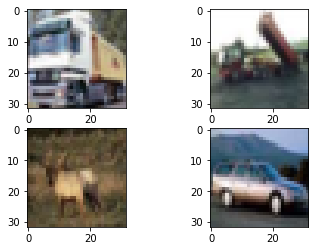

In [4]:
fig, axs = plt.subplots(2, 2) #Crea una matriz 2x2 para los subplots
axs[0,0].imshow(x_train[1])
axs[0,1].imshow(x_train[2])
axs[1,0].imshow(x_train[3])
axs[1,1].imshow(x_train[4])
plt.show()

Vamos a hacer una limpieza de datos comenzando por reducir la dimension de las imagenes. Sabemos que las matrices van de 0 a 255, entonces vamos a volver los numeros de 0 a 1 asi:

In [5]:
x_train = x_train.astype('float32')/255  #Quedaran imagenes de 32x32 en 3 distintas capas
x_test = x_test.astype('float32')/255

Vamos a reducir tambien o reestructurar los arreglos para los labels.

In [6]:
num_clases = len(np.unique(y_train)) #Hay 10 posibles numeros aca
y_train = to_categorical(y_train, num_clases) #To categorical vuelve los valores de clasificacion en un binario
y_test = to_categorical(y_test, num_clases) #Arreglo de 10 posibilidades donde marca el 1 donde esta la clase

Vamos a dividir nuestro set de entrenamiento en set de validacion, entrenamiento y test

In [7]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape:', x_train.shape)

print('train:', x_train.shape[0]) #Usara 45000 imagenes
print('val:', x_valid.shape[0]) #Usara 5000 imagenes
print('test:', x_test.shape[0]) #Usara 10000 imagenes

x_train shape: (45000, 32, 32, 3)
train: 45000
val: 5000
test: 10000


Creacion de modelo

In [8]:
base_filtros = 32
w_regularizer = 1e-4

In [9]:
model = Sequential()
#Vamos a stakear capas

##CONVOLUCION 1
#en el parentesis hay: (Conv2D(#filtros, tamano de kernel, padding, kernel regularizer))
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=x_train.shape[1:])) 
#capa de activacion Relu
model.add(Activation('relu'))

##CONVOLUCION 2
#No necesita definir entrada porque esta se ve definida por la capa anterior
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de maxpooling (Se hara cada 2 capas) para reducir la complejidad del modelo
model.add(MaxPooling2D(pool_size=(2,2))) #El pool size o kernel sera de 2x2
#capa de dropout para vigilar el overfiting
model.add(Dropout(0.2))

##CONVOLUCION 3
#Se hara mas profunda. El doble de filtros
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de dropout
model.add(Dropout(0.2))

##CONVOLUCION 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de maxpooling
model.add(MaxPooling2D(pool_size=(2,2)))
#capa de dropout
model.add(Dropout(0.3))

##CONVOLUCION 5
#Aun mas profunda. 4 veces mas filtros
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))

##CONVOLUCION 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#capa de maxpooling
model.add(MaxPooling2D(pool_size=(2,2)))
#capa de dropout
model.add(Dropout(0.4))

##CLASIFICACION Y FLATTEN
#capa flatten para agregar todo el resultado de la ultima convolucion se va a llevar a una unica dimension
model.add(Flatten())
#capa fully conect densa para la clasificacion de las imagenes
model.add(Dense(num_clases, activation='softmax'))

model.summary()


2023-01-25 13:18:45.884175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 13:18:45.885160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 13:18:46.042009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 13:18:46.043003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 13:18:46.044228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

2023-01-25 13:18:46.049734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 13:18:46.303505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 13:18:46.304377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 13:18:46.305179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Vamos a compilar el modelo

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
             metrics=['accuracy'])

Entrenamiento del modelo

In [11]:
#el batch size indica que va a tomar lotes de a 32 imagenes por iteracion
#Si hay poquitas imagenes no hay necesidad de darle este paremetro, pero si hay muchas como en este caso, si se debe usar
#A mayor batch size, mas recursos va a consumir.
hist = model.fit(x_train, y_train, batch_size=32, epochs=100,
                validation_data=(x_valid, y_valid),
                verbose=2, shuffle=True) #Como se van a ver los datos, mezcla de datos

2023-01-25 13:18:51.260920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-25 13:18:53.890196: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1407/1407 - 18s - loss: 1.6902 - accuracy: 0.3921 - val_loss: 1.4696 - val_accuracy: 0.4986
Epoch 2/100
1407/1407 - 8s - loss: 1.2609 - accuracy: 0.5662 - val_loss: 1.1990 - val_accuracy: 0.5936
Epoch 3/100
1407/1407 - 8s - loss: 1.1039 - accuracy: 0.6264 - val_loss: 1.0763 - val_accuracy: 0.6352
Epoch 4/100
1407/1407 - 7s - loss: 1.0137 - accuracy: 0.6671 - val_loss: 1.0537 - val_accuracy: 0.6600
Epoch 5/100
1407/1407 - 7s - loss: 0.9547 - accuracy: 0.6885 - val_loss: 0.8773 - val_accuracy: 0.7204
Epoch 6/100
1407/1407 - 8s - loss: 0.9158 - accuracy: 0.7082 - val_loss: 0.8340 - val_accuracy: 0.7380
Epoch 7/100
1407/1407 - 8s - loss: 0.8923 - accuracy: 0.7215 - val_loss: 0.8504 - val_accuracy: 0.7402
Epoch 8/100
1407/1407 - 8s - loss: 0.8762 - accuracy: 0.7275 - val_loss: 0.8083 - val_accuracy: 0.7510
Epoch 9/100
1407/1407 - 7s - loss: 0.8592 - accuracy: 0.7350 - val_loss: 0.8216 - val_accuracy: 0.7500
Epoch 10/100
1407/1407 - 8s - loss: 0.8572 - accuracy: 0.7372 - val_loss: 0.8353 - v

Visualizacion de comportamiento 

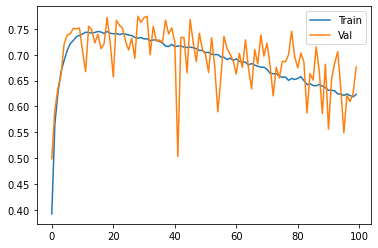

In [12]:
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.legend()
plt.show()

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.0571 - accuracy: 0.6756


[1.0570818185806274, 0.675599992275238]